In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fake-and-real-news-dataset


In [3]:
import re
import string
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# **Custom Tokenizer**

In [4]:

# Contraction map
CONTRACTION_MAP = {
    "don't": ["do", "not"], "can't": ["can", "not"], "won't": ["will", "not"],
    "i'm": ["i", "am"], "he's": ["he", "is"], "she's": ["she", "is"],
    "it's": ["it", "is"], "they're": ["they", "are"], "we're": ["we", "are"],
    "didn't": ["did", "not"], "hasn't": ["has", "not"], "wasn't": ["was", "not"],
    "wouldn't": ["would", "not"], "i've": ["i", "have"], "you've": ["you", "have"],
    "i'll": ["i", "will"], "you'll": ["you", "will"], "we'll": ["we", "will"]
}

# Emoticon regex (basic ones)
EMOTICON_REGEX = r'[:;=8][-~]?[)D(\[\]pP/\\|*]'

def custom_tokenizer(text):
    tokens = []
    text = text.lower().strip()

    # Handle emoticons first
    emoticons = re.findall(EMOTICON_REGEX, text)
    text = re.sub(EMOTICON_REGEX, ' ', text)

    # Normalize contractions (word by word)
    words = text.split()
    normalized_words = []
    for word in words:
        if word in CONTRACTION_MAP:
            normalized_words.extend(CONTRACTION_MAP[word])
        else:
            normalized_words.append(word)

    for word in normalized_words:
        # Handle elongated words (soooo → so + <REPEAT:4>)
        match = re.search(r'(.)\1{2,}', word)
        if match:
            base = re.sub(r'(.)\1{2,}', r'\1', word)
            repeat_count = len(match.group(0)) 
            tokens.append(base)
            tokens.append(f'<REPEAT:{repeat_count}>')
            continue

        # Separate punctuation from words (e.g., "hello!!!" → "hello", "!", "!", "!")
        word = re.sub(r'([!?.,:;\"\'()\[\]{}])', r' \1 ', word)
        word = re.sub(r'\s+', ' ', word)
        tokens.extend(word.strip().split())

    # Add emoticons back as separate tokens
    tokens.extend(emoticons)

    return tokens

# **Rule-Based POS Tagger**

In [5]:

""" Assigned simple POS tags to tokens based on suffixes and regex rules."""
suffix_rules = {
        'VERB': ['ing', 'ed', 'ify', 'ise', 'ize', 's', 'en','d'],
        'NOUN': ['tion', 'ment', 'ness', 'ity', 'age', 'ance', 'ence', 'hood', 'ship', 'ism', 'ist'],
        'ADJ':  ['able', 'ible', 'al', 'ant', 'ent', 'ful', 'ic', 'ive', 'less', 'ous', 'y'],
        'ADV':  ['ly', 'ward', 'wise']
    }

# Common pronouns
pronouns = set([
        'i', 'you', 'he', 'she', 'it', 'we', 'they',
        'me', 'him', 'her', 'us', 'them',
        'my', 'your', 'his', 'its', 'our', 'their',
        'mine', 'yours', 'hers', 'ours', 'theirs',
        'this', 'that', 'these', 'those'
    ])


#Irregular Verbs
irregular_verbs = {
    'was': 'be', 'were': 'be', 'am': 'be', 'is': 'be', 'are': 'be',
    'went': 'go', 'gone': 'go',
    'did': 'do', 'done': 'do',
    'had': 'have', 'has': 'have',
    'ran': 'run', 'running': 'run',
    'took': 'take', 'taken': 'take',
    'made': 'make', 'making': 'make',
    'saw': 'see', 'seen': 'see',
    'said': 'say', 'saying': 'say',
    'got': 'get', 'getting': 'get',
    'came': 'come', 'coming': 'come'
}

def mini_pos_tagger(tokens):

    tagged = []

    for token in tokens:
        lower = token.lower()

        # Punctuation
        if re.fullmatch(r'\W+', token):
            tagged.append((token, 'PUNCT'))
            continue

        # Numbers
        if re.fullmatch(r'\d+(\.\d+)?', token):
            tagged.append((token, 'NUM'))
            continue

        # Pronouns
        if lower in pronouns:
            tagged.append((token, 'PRON'))
            continue

        # Check suffixes
        matched = False
        for tag, suffixes in suffix_rules.items():
            for suf in suffixes:
                if lower.endswith(suf):
                    tagged.append((token, tag))
                    matched = True
                    break
            if matched:
                break

        # Fallbacks
        if not matched:
            if lower.endswith('s') and len(lower) > 3:
                tagged.append((token, 'NOUN'))  # plural noun guess
            elif re.fullmatch(r'[A-Z][a-z]+', token):  # Capitalized word
                tagged.append((token, 'NOUN'))  # Proper noun guess
            else:
                tagged.append((token, 'OTHER'))

    return tagged


# **Custom Lemmatizer**

In [6]:

def lemmatize_word(word, pos):
    
    # VERBS
    if pos == 'VERB':
        if word in irregular_verbs:
            return irregular_verbs[word]
        for suffix in sorted(suffix_rules['VERB'], key=len, reverse=True):
            if word.endswith(suffix) and len(word) > len(suffix) + 1:
                return re.sub(f'{suffix}$', '', word)
        return word

    # NOUNS
    elif pos == 'NOUN':
        for suffix in sorted(suffix_rules['NOUN'], key=len, reverse=True):
            if word.endswith(suffix) and len(word) > len(suffix) + 1:
                if suffix == 'ies':
                    return re.sub(r'ies$', 'y', word)
                return re.sub(f'{suffix}$', '', word)
        return word

    # ADJECTIVES and ADVERBS
    elif pos in ['ADJ', 'ADV']:
        for suffix in sorted(suffix_rules[pos], key=len, reverse=True):
            if word.endswith(suffix) and len(word) > len(suffix) + 1:
                return re.sub(f'{suffix}$', '', word)
        return word

    # PRONOUNS
    elif pos == 'PRON':
        return word

    # NUMBERS
    elif pos == 'NUM':
        return word  

    # PUNCTUATION
    elif pos == 'PUNCT':
        return word 
        
    # OTHER / fallback
    else:
        return word


def lemmatize_tokens(tagged_tokens):
    return [lemmatize_word(token, pos) for token, pos in tagged_tokens]


# **Stop-Word Removal**

In [7]:
CUSTOM_STOP_WORDS = {
    'the', 'a', 'an', 'and', 'or', 'but', 'if', 'because', 'as',
    'of', 'at', 'by', 'for', 'with', 'about', 'against',
    'between', 'into', 'through', 'during', 'before', 'after',
    'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out',
    'on', 'off', 'over', 'under', 'again', 'further', 'then',
    'once', 'here', 'there', 'when', 'where', 'why', 'how',
    'all', 'any', 'both', 'each', 'few', 'more', 'most', 'some',
    'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
    'can', 'will', 'just', 'should', 'could', 'would',
    # EXCEPTIONS: intentionally keeping negations for fake detection
    # 'not', 'no', 'never' — these are useful signals!
}

def remove_stop_words(token_list, pos_tags=None, remove_pos_types=None):
    """
        remove_pos_types: list of POS types to remove (e.g., ['PRON'])

    """
    filtered = []
    for i, token in enumerate(token_list):
        pos = pos_tags[i] if pos_tags else None

        # POS-based filtering
        if remove_pos_types and pos in remove_pos_types:
            continue

        # Stop word check (except negations)
        if token in CUSTOM_STOP_WORDS:
            continue

        filtered.append(token)

    return filtered


# **Building Vocabulary (Feature Extraction)**

In [8]:

def build_vocabulary(corpus, min_freq=5, max_vocab_size=None):
    token_counter = Counter()
    
    for text in corpus:
        tokens = custom_tokenizer(text)
        tagged = mini_pos_tagger(tokens)
        lemmas = lemmatize_tokens(tagged)
        final_tokens = remove_stop_words(lemmas)
        token_counter.update(final_tokens)
    
    # Filter by frequency
    vocab = {tok: freq for tok, freq in token_counter.items() if freq >= min_freq}
    
    # Limit vocab size
    if max_vocab_size:
        vocab = dict(sorted(vocab.items(), key=lambda x: x[1], reverse=True)[:max_vocab_size])
    
    # Assign integer IDs to tokens
    token2id = {tok: i for i, tok in enumerate(vocab)}
    return token2id, vocab


# **TF-IDF Vectorizer**


In [9]:
# --- Wrapping your pipeline into one function ---
def full_preprocess(text):
    tokens = custom_tokenizer(text)
    tagged = mini_pos_tagger(tokens)
    lemmas = lemmatize_tokens(tagged)
    final_tokens = remove_stop_words(lemmas)
    return final_tokens  # Return token list

# --- scikit-learn compatible tokenizer wrapper ---
def sklearn_tokenizer(text):
    return full_preprocess(text)

# --- TF-IDF Vectorizer ---
vectorizer_tfidf = TfidfVectorizer(
    tokenizer=sklearn_tokenizer,
    preprocessor=None,  # Skip preprocessing, we do it manually
    lowercase=False,    # Already handled in tokenizer
    token_pattern=None  # Disable internal tokenization
)

# **Visualisation of Vocabulary**

In [10]:
def plot_token_frequency(tokens, top_n=30):
    counter = Counter(tokens)
    most_common = counter.most_common(top_n)
    words, counts = zip(*most_common)
    
    plt.figure(figsize=(12,6))
    plt.bar(words, counts, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Top {top_n} Token Frequencies')
    plt.show()

def plot_wordcloud(tokens):
    text = " ".join(tokens)
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud')
    plt.show()

def plot_repeat_token_distribution(tokens):
    repeat_tokens = [tok for tok in tokens if tok.startswith('<REPEAT:')]
    counts = Counter(repeat_tokens)
    
    if not counts:
        print("No <REPEAT:n> tokens found.")
        return
    
    labels, values = zip(*sorted(counts.items()))
    plt.figure(figsize=(10,5))
    plt.bar(labels, values, color='coral')
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution of <REPEAT:n> Tokens')
    plt.show()

def plot_roc_curve(y_true, y_pred, pos_label=1, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(7,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# **Training the Classifiers (NaiveBayes and SVM)**

In [11]:
# === 5. Train Classifiers ===
def train_and_evaluate(X_train, X_test, y_train, y_test):
    classifiers = {
        "NaiveBayes": MultinomialNB(),
        "SVM": LinearSVC()
    }
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)     #Training the model
        preds = clf.predict(X_test)   #Testing the model
        print(f"\n{name} Classification Report:")    #Classification Report 
        print(classification_report(y_test, preds, zero_division=1))  
        plot_roc_curve(y_test, preds, pos_label=1, title='ROC Curve')   #ROC-AUC Curve
        sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d')    #Confusion Matrix
        plt.title(f"{name} Confusion Matrix")
        plt.show()


# **Loading and Preparing the dataset**

In [12]:
# Load the datasets
fake_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')
true_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')

# Add a label column to each
fake_df['label'] = 0  # 0 for fake news
true_df['label'] = 1  # 1 for real news

# Combine datasets vertically
combined_df = pd.concat([fake_df[['title','text', 'label']], true_df[['title','text', 'label']]], ignore_index=True)

# Optional: shuffle dataset for randomness
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

display(combined_df)

,title,text,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",1
...,...,...,...
44893,UNREAL! CBS’S TED KOPPEL Tells Sean Hannity He...,,0
44894,PM May seeks to ease Japan's Brexit fears duri...,LONDON/TOKYO (Reuters) - British Prime Ministe...,1
44895,Merkel: Difficult German coalition talks can r...,BERLIN (Reuters) - Chancellor Angela Merkel sa...,1
44896,Trump Stole An Idea From North Korean Propaga...,Jesus f*cking Christ our President* is a moron...,0


# **Visualisation of Vocabulary in the dataset**

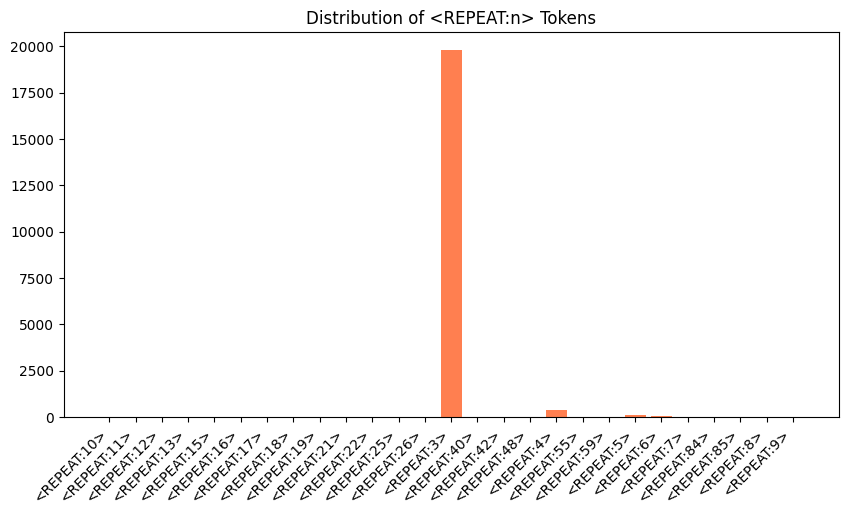

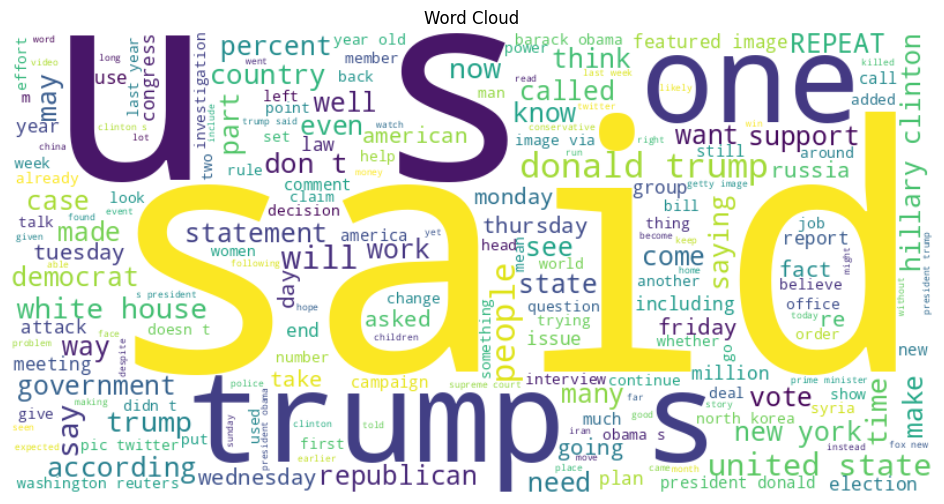

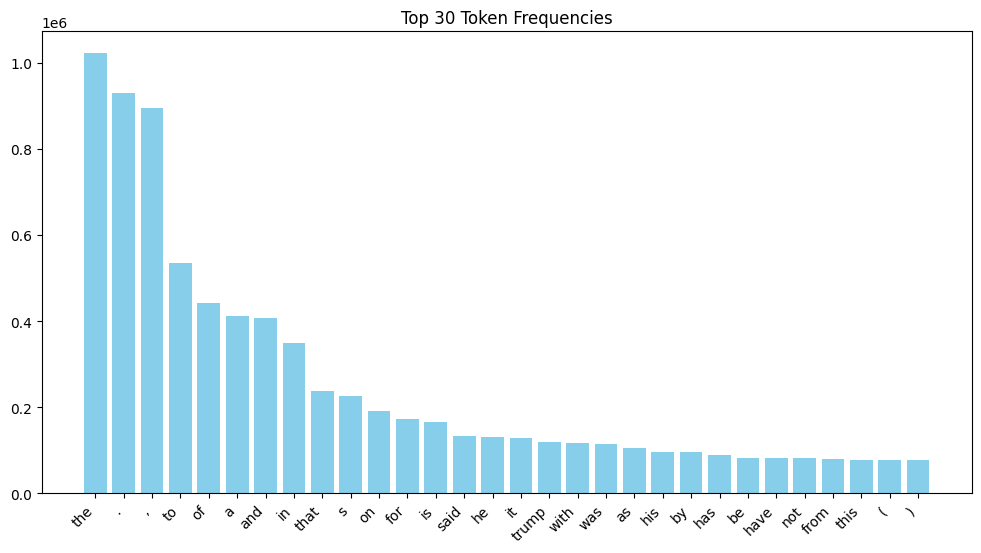

In [13]:
texts, labels = combined_df['text'], combined_df['label']

all_tokens = []

for text in texts:
    toks = custom_tokenizer(text)
    all_tokens.extend(toks)

# Now use all_tokens in your visualizations
plot_repeat_token_distribution(all_tokens)
plot_wordcloud(all_tokens)
plot_token_frequency(all_tokens, top_n=30)

# **Testing/Evaluation by VeritasVigil Model**


NaiveBayes Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4710
           1       0.96      0.98      0.97      4270

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980



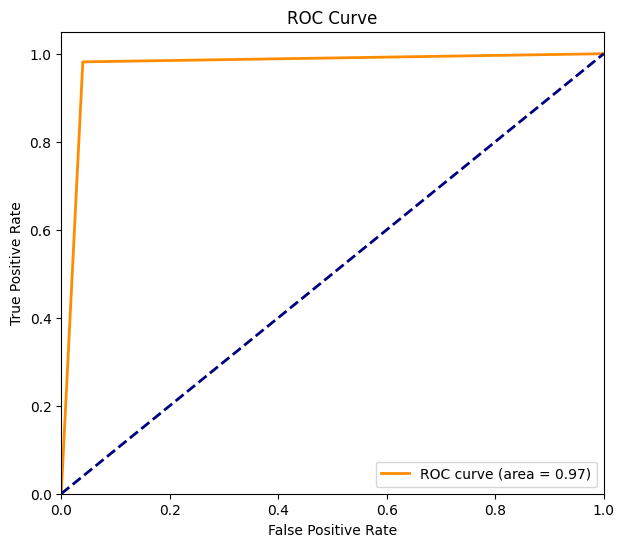

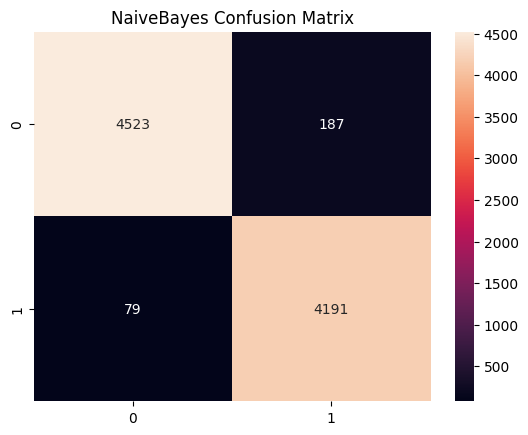


SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4710
           1       1.00      1.00      1.00      4270

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



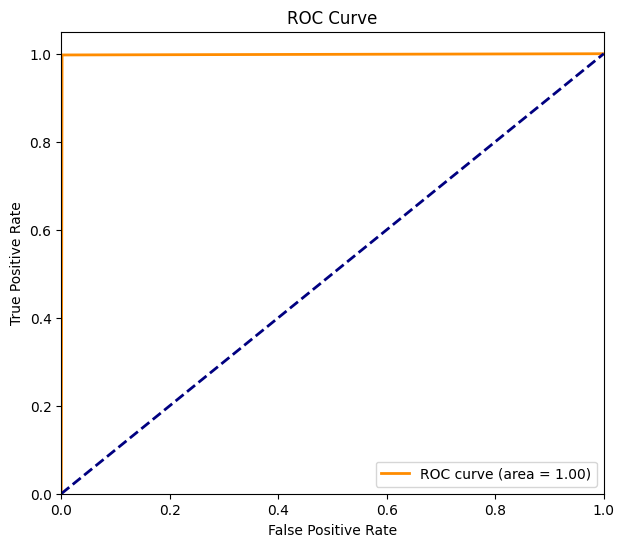

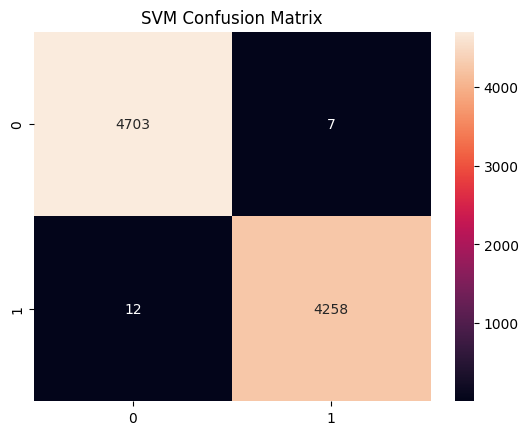

In [14]:
texts, labels = combined_df['text'], combined_df['label']
token2id = build_vocabulary(texts)
X = vectorizer_tfidf.fit_transform(texts)
y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_and_evaluate(X_train, X_test, y_train, y_test)


# **Off-the-shelf Pipeline Model**

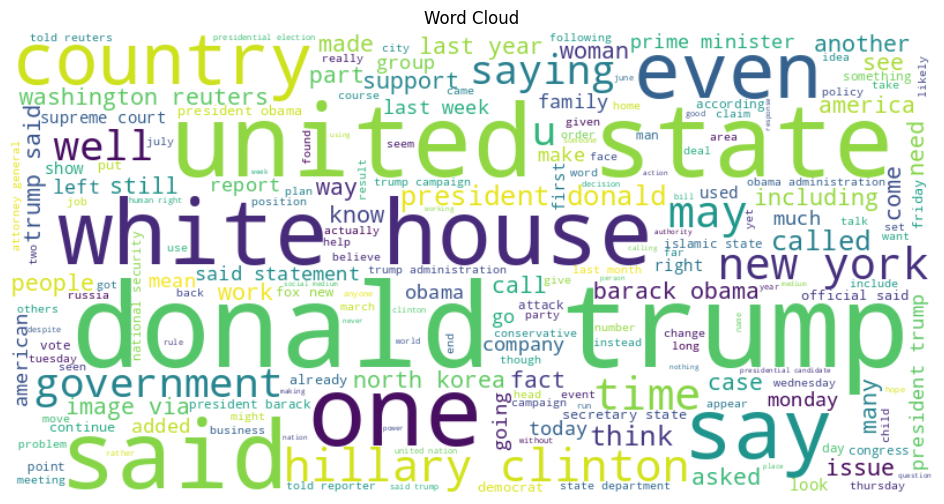


NaiveBayes Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      4696
           1       0.93      0.92      0.93      4284

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



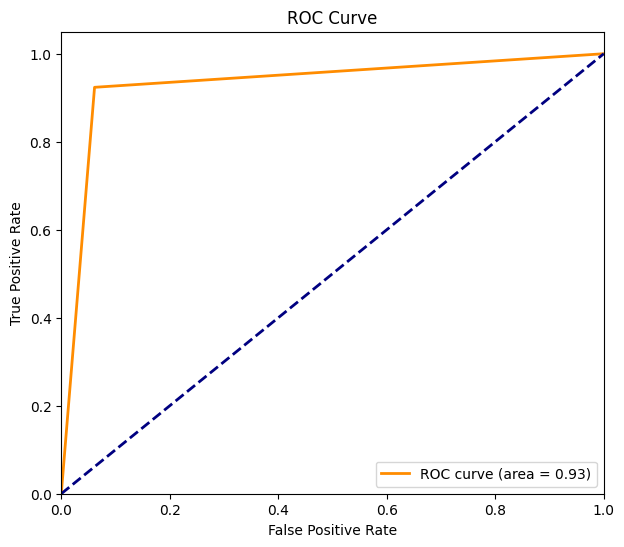

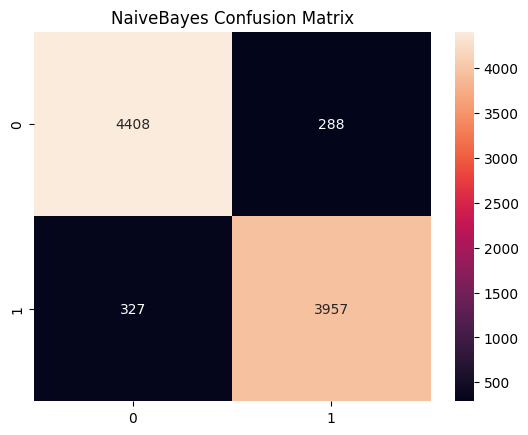


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



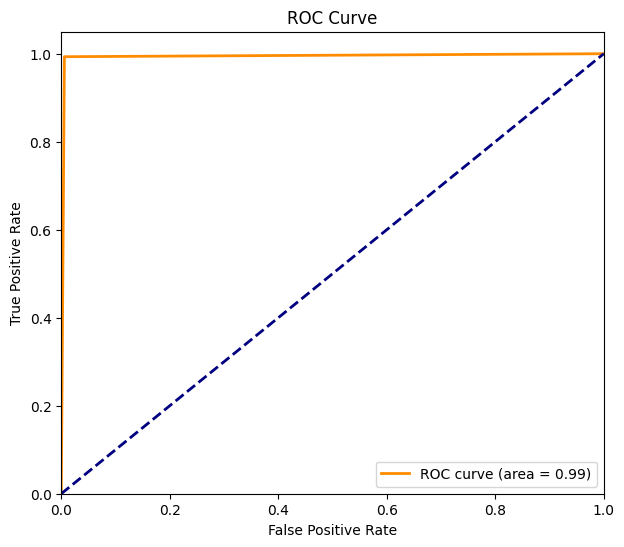

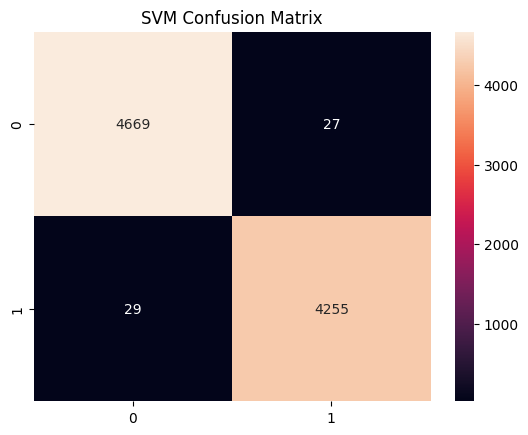

In [17]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def handle_repeated_chars(text):
    def replacer(match):
        char = match.group(1)
        count = len(match.group(0))
        return f'<REPEAT:{count}>'

    return re.sub(r'(\w)\1{2,}', replacer, text)

def nltk_preprocess(text):
    text = text.lower()
    text = handle_repeated_chars(text)  # Normalize repeated characters
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha() or word.startswith('<REPEAT:')]  # Keep <REPEAT:n> tokens
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

combined_df['clean_text'] = combined_df['text'].apply(nltk_preprocess)

plot_wordcloud(combined_df['clean_text'])

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(combined_df['clean_text'])
y = combined_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
train_and_evaluate(X_train, X_test, y_train, y_test)